(d_raster_crs_intro)=


To Do:
- show how warping works

----------------

```{admonition} Learning Objectives
Learning Objectives:
- What is warping?
- What is an affine transformation?
```
```{admonition} Review
Please Review:
* [Affine transformation](d_affine)
```
----------------




# Raster CRS 
 
Let's start from the `ndarray` `Z` that we want to span from [-90&deg;,90&deg;] longitude, and [-90&deg;,90&deg;] latitude. For more detail on the construction of these arrays please refer to [the raster section](c_rasters).

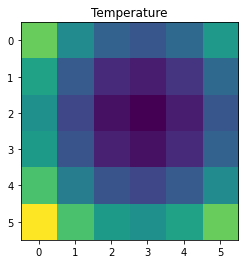

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

## Describing the Array Location
In this example the coordinate reference system will be '+proj=latlong', which describes an equirectangular coordinate reference system with units of decimal degrees. Although `X` and `Y` seems relevant to understanding the location of cell values, `rasterio` instead uses affine transformations instead. Affine transforms uses matrix algebra to describe where a cell is located (translation) and what its resolution is (scale). [Review affine transformations](d_affine_trans_scale) and [see an example here](d_affine_trans).

The affine transformation matrix can be computed from the matrix product of a translation (moving N,S,E,W) and a scaling (resolution). First, we start with translation where $\Delta x$ and $\Delta y$ define the location of the upper left hand corner of our new `Z` ndarray. As a reminder the translation matrix takes the form:

$$
   \begin{eqnarray}
     \mbox{Translate} =  \begin{bmatrix} 1 & 0 & \Delta x \\  0 & 1 & \Delta y \\ 0 & 0 & 1 \end{bmatrix}  
   \end{eqnarray}
$$

Now we can define our translation matrix using the point coordinates (`x[0]`,`y[0]`), but these need to be offset by 1/2 the resolution so that the cell is centered over the coodinate (-90,90). Notice however there are some difference between the x and y resolution:

Both arrays have the same spatial resolution

In [2]:
xres = (x[-1] - x[0]) / len(x)
xres

30.0

But notice that the y resolution is negative:

In [3]:
yres = (y[-1] - y[0]) / len(y)
yres

-30.0

In [4]:
from rasterio.transform import Affine
print(Affine.translation(x[0] - xres / 2, y[0] - yres / 2))

| 1.00, 0.00,-105.00|
| 0.00, 1.00, 105.00|
| 0.00, 0.00, 1.00|


We also need to scale our data based on the resolution of each cell, the scale matrix takes the following form:

$$
   \begin{eqnarray}
   \mbox{Scale} = \begin{bmatrix} xres & 0 & 0 \\ 0 & yres & 0 \\ 0 & 0 & 1 \end{bmatrix} 
   \end{eqnarray}
$$

In [5]:
print(Affine.scale(xres, yres))

| 30.00, 0.00, 0.00|
| 0.00,-30.00, 0.00|
| 0.00, 0.00, 1.00|


We can do both operations simultaneously in a new `transform` matrix by calculating the product of the Translate and Scale matrix: 

$$
    \mbox{Translate} \cdot \mbox{Scale} =  \begin{bmatrix} xres & 0 & \Delta x \\ 0 & yres & \Delta y \\ 0 & 0 & 1 \end{bmatrix} 
$$

In [6]:
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)
print(transform)

| 30.00, 0.00,-105.00|
| 0.00,-30.00, 105.00|
| 0.00, 0.00, 1.00|


Now we need to write out a `tif` file that holds the data in `Z` and its data type with `dtype`, the location described by `transform`, in coordinates described by the coordinate reference system `+proj=latlon`, the number of 'bands' of data in `count` (in this case just one), and the shape in `height` and `width`.

In [7]:
with rasterio.open(
    '../temp/Z.tif',
    'w',
    driver='GTiff',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(Z, 1)

NameError: name 'rasterio' is not defined

All this info is stored in `dst` and then written to disk with `dst.write(Z,1)`. Where `write` gets the array of data `Z` and the band location to write to, in this case band `1`. This is a bit awkward, but I believe is a carryover from GDAL which rasterio relies on heavily (like all other platforms including arcmap etc). 




### The Crazy Tale of the Upper Left Hand Corner
To help us understand what is going on it helps to work an example. For our example above we need to define the translate matrix that helps define the upper left hand corner of our rainfall raster data `Z`. In particular we need the upper left cell center to be located at (-90,90), so the upper left hand corner need to be 1/2 the resolution above and to the left of (-90,90), implying a location of (-105,105) since the resolution is 25 degrees.

We can visualize what we need to do here: 

```{figure} ../_static/c_data_types/c_raster_upperleft_drawing.png
:name: Example of using affine translation to shift the upper left hand corner
:width: 500px
Example of using translation to shift the upper left hand corner
```

Let's walk through the math behind the scenes. Here we use our transform matrix to move our upper left hand corner which is assumed to start at the origin (0,0).

```{figure} ../_static/c_data_types/c_raster_upperleft_transform.png
:name: Example of using affine translation of a matrix to shift the upper left hand corner
:width: 500px
Example of using affine translation of a matrix to shift the upper left hand corner
```
The final coordinate of the upper left hand corner are $(x_0,y_0) = (-105,105)$


### Translate is a "map"
Now here's the magic, our new `translate` matrix can be used to easily find the coordinates of any cell based on its row and column number. To see how if works, we are going to multiply our `translate` matrix by `(row_number, column_number)` to retrieve the coordinates of that cell's upper right hand corner. Essentially, `translate` "maps" row and column indexes to coordinates! OMG! This is fun... ok kidding, but it's useful. 

 
Let's see how we can calculate a few coordinates (upper left) based on the visual examples below:

```{figure} ../_static/c_data_types/c_raster_raster.png
:name: Example of using transform to identify coordinates based on row and column
:width: 500px
Example of using transform to identify coordinates based on row and column
```
Let's start with the easiest and retrieve the upper left corner coordinates based on `transform * (row_number, column_number)`:

In [ ]:
print(transform*(0,0))

Let's find the corner that is one cell down (-30&deg;) and to the right (+30&deg;)

In [ ]:
print(transform*(1,1))

Just to make sure it works let's find a harder one:

In [ ]:
print(transform*(5,2))

#### How transform works
Let's work the example of finding the upper left coordinates of with `row=5`, `column=2`:

$$
   \begin{eqnarray}
      \begin{bmatrix} 5 \\ 2 \\ 1 \end{bmatrix}   
      \begin{bmatrix} 
          30 & 0 & -105 \\  
          0 & -30 & 105 \\ 
          0 & 0 & 1 
      \end{bmatrix}  =
      \begin{bmatrix} 
          5 \times 30 + 2 \times 0 + 1 \times -105  \\  
          5 \times 0 + 2 \times -30 + 1 \times 105 \\ 
          5 \times 0 + 2 \times 0 + 1 \times 1  
      \end{bmatrix} = 
      \begin{bmatrix} 45  \\  45 \\ 1  \end{bmatrix}
   \end{eqnarray}
$$

Wow, it works! Come on it's at least a little bit cool. Depending on your definition of cool.

## Warping Images (Reproject)
How then do we reproject, or warp, a raster? Since `transform` is a map of pixel locations, warping a raster then becomes as simple as knowing the `transform` of your destination based on the description of the new coordinate reference system.